#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/2024.11.13_미니프로젝트 6차_1일차 실습자료/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
def make_dataset_3(Product_ID):

  # 데이터 합치기
  temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
  temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
  temp3 = pd.merge(temp1, temp2)
  temp3['target'] = temp3['Qty'].shift(-2)  # 2일 후의 판매량
  temp3.dropna(inplace = True)

  # 날짜 요소 추출
  temp3['WeekDay'] = temp3['Date'].dt.day_name()
  temp3['Month'] = temp3['Date'].dt.month

  return temp3

In [ ]:
def preproc3d_3(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
df_3 = make_dataset_3(3)
df_3.head()

* **모델링**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d_3(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(32, input_shape=(ts, nfeat), return_sequences=True),
                         Dropout(0.2),
                         LSTM(16, return_sequences=True),
                         Dropout(0.2),
                         LSTM(8),
                         Dense(16, activation='relu'),
                         Dense(1)])
model03_01.summary()

model03_01.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = model03_01.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[early_stopping]).history

dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred2 = pred * (y_max - y_min) + y_min  # 예측값을 원래 스케일로 복원
y_val2 = y_val * (y_max - y_min) + y_min  # 실제값을 원래 스케일로 복원

print('RMSE : ', root_mean_squared_error(y_val,pred))
print('MAE : ', mean_absolute_error(y_val, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val, pred))
print('R2 : ',r2_score(y_val, pred))
print('------------------------')
print('RMSE : ', root_mean_squared_error(y_val2,pred2))
print('MAE : ', mean_absolute_error(y_val2, pred2))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred2))
print('R2 : ',r2_score(y_val2, pred2))

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred2)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
import joblib

In [ ]:
def preproc3d_12(data, timesteps, y_scale=False):
    target = 'Target_Qty'
    scaled_columns = ['Qty', 'CustomerCount']

    # x와 y 분리
    x = data.drop(['Date', target], axis=1)
    y = data[target]

    # 스케일링 (특정 열만)
    scaler = MinMaxScaler()
    if any(col in x.columns for col in scaled_columns):
        # 스케일링할 컬럼이 있는 경우
        x[scaled_columns] = pd.DataFrame(
            scaler.fit_transform(x[scaled_columns]),
            columns=scaled_columns,
            index=x.index
        )

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 데이터 분할 (시계열 데이터를 고려하여 분할)
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=60, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max


In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d_12(df_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

* **모델링**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

clear_session()

_, ts, nfeat = x_train.shape

# 모델 정의
model12_02 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(ts, nfeat)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16, return_sequences=False),  # 마지막 LSTM만 return_sequences=False
    Dense(8, activation='relu'),
    Dense(1)
])

# 모델 요약
model12_02.summary()

# 모델 컴파일
model12_02.compile(optimizer=Adam(learning_rate=0.005), loss='mse')


# Early Stopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,     # 성능이 개선되지 않는 에포크 수
    restore_best_weights=True  # 가장 좋은 모델의 가중치를 복원
)

# 모델 학습
hist = model12_02.fit(
    x_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
).history

In [ ]:
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
mydataset = joblib.load(path + 'myinterested_file_2.pkl')
mydataset

In [ ]:
decomp = sm.tsa.seasonal_decompose(mydataset['Qty'], model = 'additive', period = 12)
result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

In [ ]:
#시계열 분해 데이터
result = result.bfill()
result = result.ffill()

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

result = result[['trend','seasonal','residual']]

,Date,Qty,CustomerCount,target,WeekDay,Month
0,2014-01-02,76.0,4422,78.0,Thursday,1
1,2014-01-03,74.0,4167,88.0,Friday,1
2,2014-01-04,78.0,5341,65.0,Saturday,1
3,2014-01-05,88.0,5123,78.0,Sunday,1
4,2014-01-06,65.0,3917,73.0,Monday,1


In [ ]:
my_dataset = pd.concat([mydataset,result],axis=1)
my_dataset.drop(columns='Date',inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

my_dataset['FutureQty'] = my_dataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
target = 'FutureQty'

X = my_dataset.drop(columns=target)
y = my_dataset[target]
X_train = X[:-60]
y_train = y[:-60]
X_valid = X[-60:-2]
y_valid = y[-60:-2]

X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']] = scaler.fit_transform(X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']]= scaler.transform(X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_train

In [ ]:
timesteps = 14
X_train,y_train = temporalize(X_train,y_train,timesteps)
X_valid,y_valid = temporalize(X_valid,y_valid,timesteps)

* **모델링**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping,ModelCheckpoint

model = Sequential()
model.add(LSTM(units=128,return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())
es = EarlyStopping(monitor='val_loss',patience=30)
mc = ModelCheckpoint('CheckPoint/best_lstm.keras',save_best_only=True,monitor='val_loss',mode='min')
# 모델 훈련
model.fit(X_train, y_train,validation_data=[X_valid,y_valid], epochs=100, batch_size=8, callbacks=[es,mc])

# 예측
predictions = model.predict(X_valid)


(45.0, 196.0, (1078, 7, 21), (60, 7, 21))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 32)               │           6,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

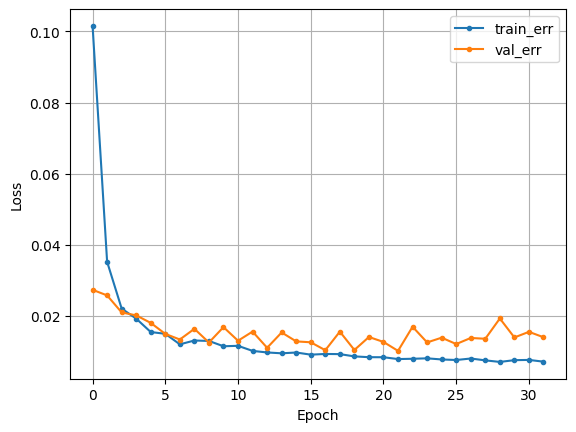

In [ ]:
plt.figure()
plt.plot(y_valid,label='True')
plt.plot(predictions[:,0],label='Predictions')
plt.title("LSTM Model")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score
print(r2_score(y_valid,predictions))
mean_absolute_error(y_valid,predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
RMSE :  0.08118986619959485
MAE :  0.06197836380328563
MAPE :  0.2717632861305949
R2 :  0.3465049558957136
------------------------
RMSE :  12.25967042892339
MAE :  9.358733495076498
MAPE :  0.1075344806123049
R2 :  0.34650488843523597


## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
#Product 3 파이프라인
def pp_data(sales, orders, oil_price, products, stores, y_scale = False, Use3D = False) :
  temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3), ['Date','Qty']]
  temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
  temp3 = pd.merge(temp1, temp2)
  temp3['target'] = temp3['Qty'].shift(-2)
  temp3.dropna(inplace = True)
  temp3['WeekDay'] = temp3['Date'].dt.day_name()
  temp3['Month'] = temp3['Date'].dt.month

  Category = products.loc[products['Product_ID'].isin([3]), 'Category'].to_list()
  Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
  temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
  temp4.columns = ['Date', 'Category_Qty']
  temp3 = pd.merge(temp3, temp4, how = 'left')

  City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
  Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
  temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
  temp5.columns = ['Date', 'City_CustCount']
  temp3 = pd.merge(temp3, temp5, how = 'left')
  temp3 = pd.merge(temp3, oil_price, how='left')
  temp3['WTI_Price'] = temp3['WTI_Price'].interpolate(method='linear')

  target = 'target'
  x = temp3.drop(['Date', target], axis = 1)
  y = temp3.loc[:, target]
  x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
  x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
  x = pd.get_dummies(x, columns = ['WeekDay','Month'])

  scaler = MinMaxScaler()
  x = scaler.fit_transform(x)

  if y_scale:
      y_min, y_max = y.min(), y.max()
      y = (y - y_min) / (y_max - y_min)
  else:
      y_min, y_max = np.nan, np.nan

  x3, y3 = temporalize(x, y, 7)

  if Use3D:
      _, x_test, _, y_test = train_test_split(x3, y3, test_size=0.2, shuffle=False)
  else:
      _, x_test, _, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

  return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
def pp_data(sales, orders, oil_price, products, stores, y_scale=False, Use3D=False):
    # Product 12인 경우
    # 데이터 전처리
    sales = sales[sales['Store_ID'] == 44]
    sales = sales[sales['Product_ID'] == 12]
    orders = orders[orders['Store_ID'] == 44]
    df = pd.merge(sales, orders, on=['Date', 'Store_ID'], how='inner')
    df['Month'] = df['Date'].dt.month
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Target_Qty'] = df['Qty'].shift(-2)
    df.drop(columns=['Store_ID', 'Product_ID', 'Day_of_Week'], inplace=True)
    df['Customer_Growth'] = df['CustomerCount'].pct_change()
    correlation = df[['CustomerCount', 'Qty']].corr()
    df['Target_Qty'] = df['Target_Qty'].fillna(method='ffill')
    df['Customer_Growth'].fillna(0, inplace=True)

    # 타겟값 지정
    target = 'Target_Qty'
    scaled_columns = ['Qty', 'CustomerCount']
    x = df.drop(['Date', target], axis=1)
    y = df[target]

    # 스케일링 시작
    scaler = MinMaxScaler()
    # 스케일링 지정 칼럼이 있는 경우
    if any(col in x.columns for col in scaled_columns):
        x[scaled_columns] = pd.DataFrame(
            scaler.fit_transform(x[scaled_columns]),
            columns=scaled_columns,
            index=x.index
        )
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 3차원 변환 & timestep : 7
    x3, y3 = temporalize(x, y, 7)

    if Use3D:
        _, x_test, _, y_test = train_test_split(x3, y3, test_size=0.2, shuffle=False)
    else:
        _, x_test, _, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

    return x_test, y_test

In [ ]:
#Product 42 파이프라인
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

dataset_test = pd.merge(sales_test,products,how='left',on='Product_ID') # 판매수량 및 가격과 리드타임과 정보에 관한 정보 merge
dataset_test = pd.merge(dataset_test,stores,how='left',on='Store_ID') # 매장에 관한 정보도 추가
dataset_test = pd.merge(dataset_test,oil_price_test,how='left',on='Date') # 매장에 대한 유가정보도 추가
dataset_test = pd.merge(dataset_test,orders_test,how='left',on=['Date','Store_ID']) # 매장에 대한 고객 방문 수 정보 추가
myinterested_test = dataset_test.loc[(dataset_test['Store_ID']==44) & (dataset_test['Product_ID']==42)]

# 미국 연방 공휴일 기준
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def preprocessing4predict_42(test_dataset,CAT_COL = ['year','weekday','month'], NUM_COL = ['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice'],train_dataset=my_dataset):
    test_dataset.drop(columns=['Product_Code','Store_Type','SubCategory','Category','Store_ID','Product_ID','State','City','LeadTime'],inplace=True)
    test_dataset.reset_index(drop=True,inplace=True) # 인덱스 번호 초기화
    test_dataset['Qty'].astype(int)
    test_dataset['year'] = test_dataset['Date'].dt.year
    test_dataset['weekday'] = test_dataset['Date'].dt.weekday
    test_dataset['month'] = test_dataset['Date'].dt.month
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays()

    test_dataset['holiday'] = np.where((test_dataset['weekday'] >= 5) | (test_dataset['Date'].isin(holidays)), 1, 0)
    test_dataset['OverQtyMonth'] = test_dataset['month'].map({1:0,2:0,3:0,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:0}) # 판매량 평균을 넘어가는 달에 대해 추가 칼럼으로 0,1을 만들어주었다.
    test_dataset['Summer'] = test_dataset['month'].map({5:1,6:1,7:1,8:1,1:0,2:0,3:0,4:0,9:0,10:0,11:0,12:0}) # 여름에 잘 팔리는 상품인 것 같아서 여름인가? 에 대한 칼럼을 추가로 만들어줌
    test_dataset['WTI_Price'] = test_dataset['WTI_Price'].bfill() # 유가 데이터는 주변 데이터와 비슷하거나 동일할 것이라고 생각되어 bbfill 근접한 데이터를 사용해서 채워줌

    imputer = KNNImputer(n_neighbors=3)
    test_dataset['CustomerCount'] = imputer.fit_transform(test_dataset[['Qty','CustomerCount','holiday']])[:,1] # 위에서 공휴일과 아닐때의 방문 차이가 있으니 공휴일과 판매량도 고려해서 결측치 해결
    test_dataset[['CustomerCount','Qty']] = test_dataset[['CustomerCount','Qty']].astype(int)
    test_dataset = test_dataset.rename(columns= {'holiday':'IsHoliday','Summer':'IsSummer','OverQtyMonth':'IsOverQtyMonth'})
    test_dataset['TotalPrice'] = test_dataset['Price']*test_dataset['Qty']
    test_dataset.drop(columns='Price',inplace=True)

    test_dataset = pd.get_dummies(test_dataset,columns=CAT_COL,dtype=int) # 순위가 없으므로 year와 weekday와 month는 원핫인코딩으로 학습 필요
    decomp = sm.tsa.seasonal_decompose(test_dataset['Qty'], model = 'additive', period = 12)
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    result = result.bfill()
    result = result.ffill()
    result = result[['trend','seasonal','residual']]

    test_dataset = pd.concat([test_dataset,result],axis=1)
    test_dataset.drop(columns='Date',inplace=True)
    test_dataset['FutureQty'] = test_dataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
    target = 'FutureQty'

    X_test = test_dataset.drop(columns=target)
    y_test = test_dataset[target]

    scaler = StandardScaler()
    scaler.fit(train_dataset[NUM_COL])
    X_test[NUM_COL] = scaler.transform(X_test[NUM_COL])
    X_test['year_2015'] = [0] * 31
    X_test['year_2016'] = [0] * 31
    X_test['month_2'] = [0] * 31
    X_test['month_4'] = [0] * 31
    X_test['month_5'] = [0] * 31
    X_test['month_6'] = [0] * 31
    X_test['month_7'] = [0] * 31
    X_test['month_8'] = [0] * 31
    X_test['month_9'] = [0] * 31
    X_test['month_10'] = [0] * 31
    X_test['month_11'] = [0] * 31
    X_test['month_12'] = [0] * 31
    new_column_order = ['Qty', 'WTI_Price', 'CustomerCount', 'IsHoliday', 'IsOverQtyMonth',
                        'IsSummer', 'TotalPrice', 'year_2015', 'year_2016', 'year_2017',
                        'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
                        'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                        'trend', 'seasonal', 'residual']
    X_test = X_test[new_column_order]
    timesteps=12
    X_test,y_test = temporalize(X_test,y_test,timesteps) # 3 차원으로 변경
    return X_test,y_test



## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
product_ID = int(input('예측할 Product ID 숫자를 입력하세요: '))

def preprocessing4predict(product_ID = 3, scaler = scaler):
    if product_ID==42:
        X_test,y_test = preprocessing4predict_42(myinterested_test,train_dataset=my_dataset)
        return X_test,y_test
    elif product_ID==3:
        return pp_data(sales=sales_test, orders=orders_test, oil_price=oil_price_test, products=products, stores=stores, y_scale=True, Use3D=True)
    elif product_ID==12:
        return pp_data(sales=sales_test, orders=orders_test, oil_price=oil_price_test, products=products, stores=stores, y_scale=True, Use3D=True)

SyntaxError: invalid syntax (<ipython-input-16-ac0cee9af5cf>, line 1)

In [ ]:
product_ID = int(input('예측할 Product ID 숫자를 입력하세요: '))
X_test,y_test = preprocessing4predict(product_ID)

* 예측해보기

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**
